In [71]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.tsa.stattools import ccovf,ccf
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.graphics.tsaplots import month_plot,quarter_plot, seasonal_plot


In [2]:
test_set_start_date = pd.to_datetime('2019-12-01')
prediction_period = 7

In [3]:
def model_metrics(y_true, predictions, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)
    mea = mean_absolute_error(y_true=y_true, y_pred=predictions)

    return pd.DataFrame(data = [{'Model': model_name, 'rmse': rmse, 'r2': r2, 'mea' : mea}])

### Data Preparation

In [22]:
restaurant_data = pd.read_csv('Data/AggData.csv', index_col=0, infer_datetime_format=True)
restaurant_data.index = pd.to_datetime(restaurant_data.index)
restaurant_data = restaurant_data.asfreq(pd.infer_freq(restaurant_data.index))

In [96]:
restaurant_data['DoW'] = restaurant_data.index.day_of_week

### EDA

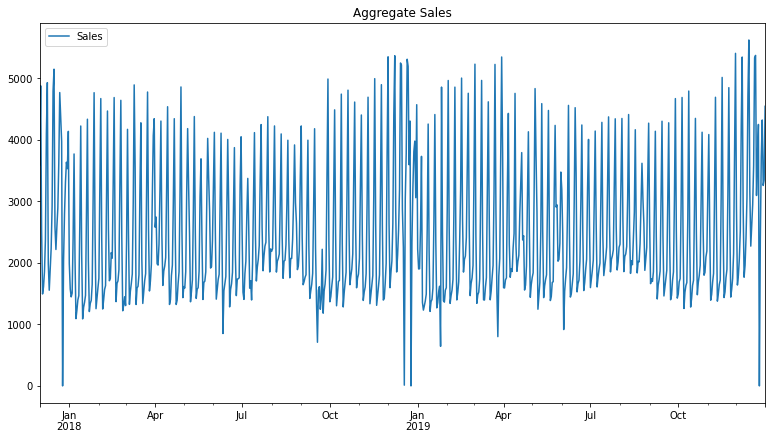

In [24]:
restaurant_data.plot(figsize = (13,7), legend=True, title = 'Aggregate Sales');

##### Seasonal Decomposition on the whole training data set

<AxesSubplot:>

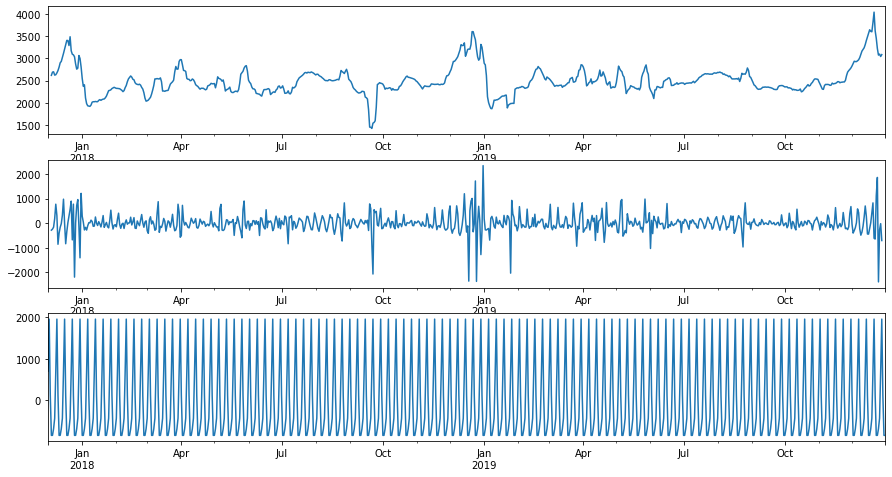

In [30]:
decomposed_data = seasonal_decompose(restaurant_data)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decomposed_data.trend.plot(ax=ax1)
decomposed_data.resid.plot(ax=ax2)
decomposed_data.seasonal.plot(ax=ax3)

##### Seasonal decomposition on only 30 days

<AxesSubplot:>

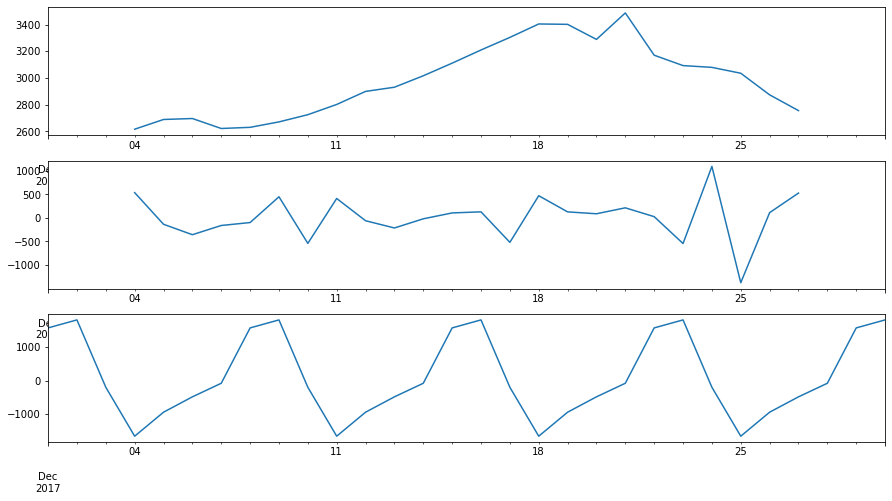

In [32]:
decomposed_data = seasonal_decompose(restaurant_data[:30])
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decomposed_data.trend.plot(ax=ax1)
decomposed_data.resid.plot(ax=ax2)
decomposed_data.seasonal.plot(ax=ax3)

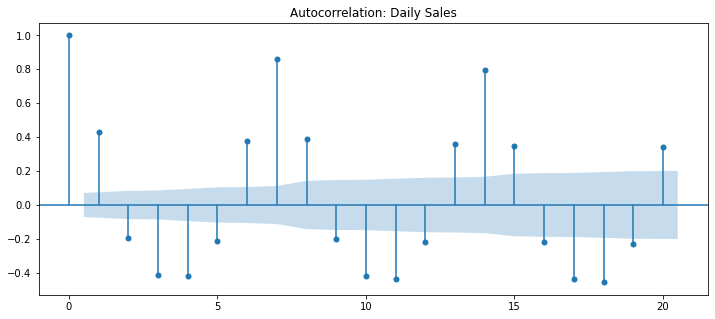

In [53]:
# Now let's plot the autocorrelation at different lags
title = 'Autocorrelation: Daily Sales'
lags = 20
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(restaurant_data,title=title,lags=lags, ax=ax);

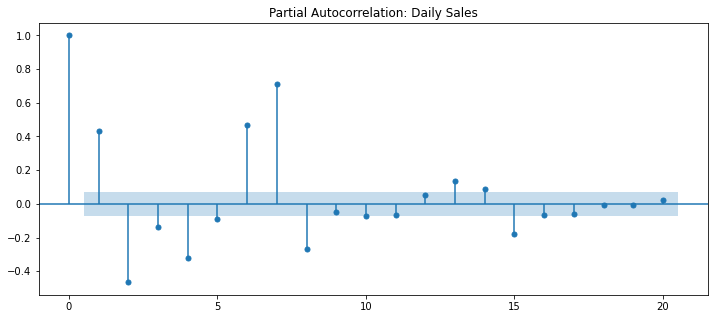

In [56]:
title='Partial Autocorrelation: Daily Sales'
lags=20
fig,ax = plt.subplots(figsize=(12,5))
plot_pacf(restaurant_data,title=title,lags=lags, ax = ax);

### Tests for Stationarity

In [61]:
print('Augmented Dickey-Fuller Test on Sales Data')
dftest = adfuller(restaurant_data['Sales'],autolag='AIC')
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on Sales Data
ADF test statistic       -3.788631
p-value                   0.003026
# lags used              20.000000
# observations          740.000000
critical value (1%)      -3.439218
critical value (5%)      -2.865454
critical value (10%)     -2.568854
dtype: float64


Here we have a very low p-value at 0.003, which provides strong evidence against the null hypothesis, and so we <em> reject</em> the null hypothesis, and decide that our dataset is stationary.<br>

### Exposing Seasonality with Month and Quarter Plots

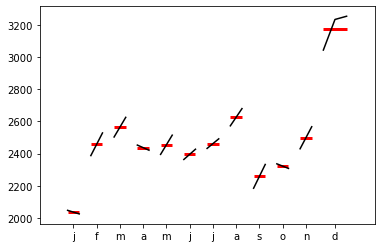

In [68]:
month_plot(restaurant_data['Sales'].resample(rule = 'M').mean());

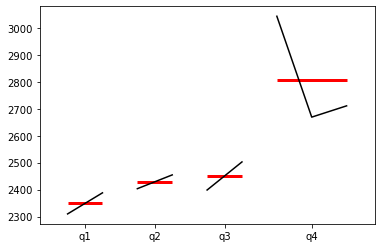

In [64]:
dfq = restaurant_data['Sales'].resample(rule='Q').mean()

quarter_plot(dfq);

### Stationarity: take first difference of this series

In [81]:
restaurant_data['FirstDifference'] = restaurant_data.Sales.diff().dropna()

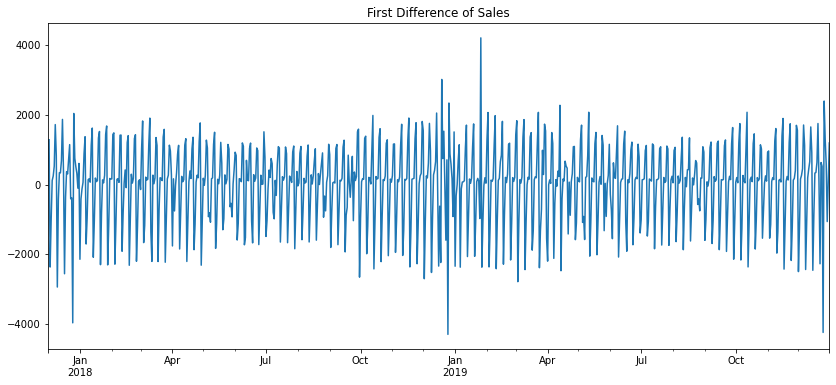

In [86]:
restaurant_data.FirstDifference.plot(figsize = (14,6), title='First Difference of Sales');

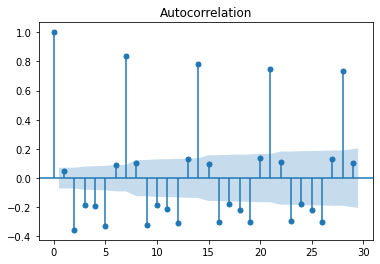

In [94]:
plot_acf(restaurant_data.FirstDifference[1:]);

In [93]:
restaurant_data.head()

,Sales,FirstDifference
2017-12-01,3592.214389,NaN
2017-12-02,4878.683762,1286.469373
2017-12-03,2508.278944,-2370.404818
2017-12-04,1494.383168,-1013.895776
2017-12-05,1610.356304,115.973135


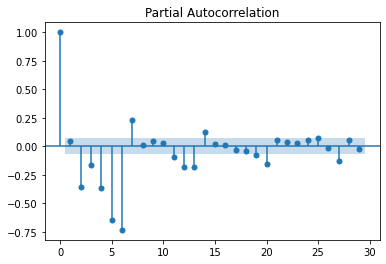

In [95]:
plot_pacf(restaurant_data.FirstDifference[1:]);

### Trying to remove seasonality

In [97]:
dow_volatility = restaurant_data.groupby('DoW').std()

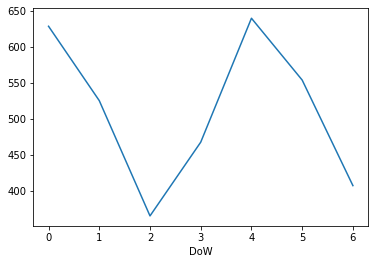

In [102]:
dow_volatility.Sales.plot();

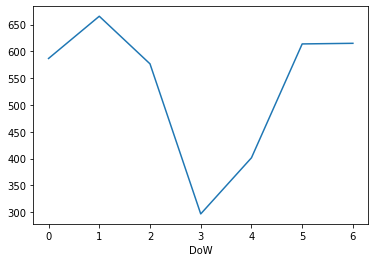

In [103]:
dow_volatility.FirstDifference.plot();

In [ ]:
restaurant_data = heater_series.index.map(lambda d: annual_volatility.loc[d.year])